In [1]:
# Set up environment variables
# IMPORTANT: Set these in your .env file or system environment variables before running
# Copy .env.example to .env and fill in your actual API keys
%env OPENAI_API_KEY=your_openai_api_key_here
%env OPENROUTER_API_KEY=your_openrouter_api_key_here


env: OPENAI_API_KEY=your_openai_api_key_here
env: OPENROUTER_API_KEY=your_openrouter_api_key_here


In [ ]:
# Import required libraries
import os
import json
import sqlite3
from typing import List, Dict, Any, Optional
import chromadb
from chromadb.config import Settings

# LangChain and LangGraph imports
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_chroma import Chroma
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage
from langchain.agents import create_agent
from langgraph.checkpoint.memory import MemorySaver

# Local imports
from utils import describe_database


## Setup Vector Database and Load SQL Examples


In [3]:
# Initialize embeddings and ChromaDB
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

# Initialize ChromaDB (clean slate)
chroma_client = chromadb.PersistentClient(
    path="./chromadb_react_agent",
    settings=Settings(anonymized_telemetry=False)
)

# Clean up existing collection if it exists
try:
    chroma_client.delete_collection("sql_examples")
except Exception:
    pass  # Ignore if collection doesn't exist

# Initialize vector store
vector_store = Chroma(
    client=chroma_client,
    collection_name="sql_examples",
    embedding_function=embeddings,
    collection_metadata={"hnsw:space": "cosine"}
)

print("✅ Vector database initialized")


✅ Vector database initialized


In [4]:
# Load and prepare SQL examples from dev.json
with open('../dev.json', 'r') as f:
    dev_data = json.load(f)

print(f"📚 Loaded {len(dev_data)} SQL examples")
print(f"Example: {dev_data[0]['question'][:100]}...")


📚 Loaded 1534 SQL examples
Example: What is the highest eligible free rate for K-12 students in the schools in Alameda County?...


In [5]:
db_names = set([d['db_id'] for d in dev_data])

db_names

{'california_schools',
 'card_games',
 'codebase_community',
 'debit_card_specializing',
 'european_football_2',
 'financial',
 'formula_1',
 'student_club',
 'superhero',
 'thrombosis_prediction',
 'toxicology'}

In [6]:
# Create documents from SQL examples
from langchain_core.documents import Document

documents = []
for item in dev_data:
    # Create comprehensive document with all relevant information
    evidences = [e.strip() for e in item['evidence'].split(';') if e.strip()]
    
    for evidence in evidences:
        doc = Document(
            page_content=evidence,
            metadata={
                "db_id": item["db_id"],
                "question": item["question"],
                "sql": item["SQL"]
            }
        )
        documents.append(doc)

# Add documents to vector store
print(f"📤 Adding {len(documents)} documents to vector store...")
# vector_store.add_documents(documents)
print(f"✅ Added {len(documents)} SQL evidence examples to the vector store")

# Show database distribution
db_counts = {}
for item in dev_data:
    db_id = item['db_id']
    db_counts[db_id] = db_counts.get(db_id, 0) + 1

print(f"\n📊 Available databases:")
for db_id, count in sorted(db_counts.items()):
    print(f"  - {db_id}: {count} examples")


📤 Adding 2680 documents to vector store...
✅ Added 2680 SQL evidence examples to the vector store

📊 Available databases:
  - california_schools: 89 examples
  - card_games: 191 examples
  - codebase_community: 186 examples
  - debit_card_specializing: 64 examples
  - european_football_2: 129 examples
  - financial: 106 examples
  - formula_1: 174 examples
  - student_club: 158 examples
  - superhero: 129 examples
  - thrombosis_prediction: 163 examples
  - toxicology: 145 examples


## Define ReAct Agent Tools


In [7]:
@tool
def look_up_evidence(query: str, database_id: str = "", k: int = 5) -> str:
    """
    Look up relevant SQL evidence/examples from the vector database.
    
    Args:
        query: The question or query to find relevant SQL examples for
        database_id: Optional database ID to filter results (e.g., 'formula_1', 'california_schools')
        k: Number of examples to retrieve (default: 5)
    
    Returns:
        String containing relevant SQL evidence and examples
    """
    
    try:
        # Perform similarity search with optional filtering
        search_kwargs = {"k": k}
        if database_id:
            search_kwargs["filter"] = {"db_id": database_id}
        
        results = vector_store.similarity_search_with_score(query, **search_kwargs)
        
        if not results:
            return f"No relevant evidence found for query: '{query}'"
        
        # Format results
        evidence_text = f"Found {len(results)} relevant examples:\n\n"
        
        for i, (doc, score) in enumerate(results, 1):
            similarity = 1 - score  # Convert distance to similarity
            evidence_text += f"Example {i} (similarity: {similarity:.3f}):\n"
            evidence_text += f"Database: {doc.metadata['db_id']}\n"
            evidence_text += f"Evidence: {doc.page_content}\n"
            if 'question' in doc.metadata:
                evidence_text += f"Related Question: {doc.metadata['question']}\n"
            if 'sql' in doc.metadata:
                evidence_text += f"SQL Example: {doc.metadata['sql']}\n"
            evidence_text += "-" * 50 + "\n"
        
        return evidence_text
        
    except Exception as e:
        error_msg = f"Error looking up evidence: {str(e)}"
        return error_msg


In [8]:
@tool
def run_sql_against_database(sql_query: str, database_id: str) -> str:
    """
    Execute a SQL query against the specified database.
    
    Args:
        sql_query: The SQL query to execute
        database_id: The database identifier (e.g., 'formula_1', 'california_schools')
    
    Returns:
        String containing the query results or error message
    """
    
    try:
        # Construct database path
        db_path = f"../dbs/dev_databases/{database_id}/{database_id}.sqlite"
        
        if not os.path.exists(db_path):
            return f"Error: Database '{database_id}' not found at {db_path}"
        
        # Connect and execute query
        conn = sqlite3.connect(db_path)
        cursor = conn.cursor()
        
        cursor.execute(sql_query)
        
        # Get results
        columns = [description[0] for description in cursor.description] if cursor.description else []
        results = cursor.fetchall()
        
        conn.close()
        
        # Format results
        if not results:
            result_text = "Query executed successfully but returned no results."
        else:
            result_text = f"Query executed successfully! Found {len(results)} row(s):\n\n"
            
            # Add column headers
            if columns:
                result_text += " | ".join(columns) + "\n"
                result_text += "-" * (len(" | ".join(columns))) + "\n"
            
            # Add data rows (limit to first 10 for readability)
            for row in results[:10]:
                result_text += " | ".join(str(cell) if cell is not None else "NULL" for cell in row) + "\n"
            
            if len(results) > 10:
                result_text += f"\n... and {len(results) - 10} more row(s)"
        
        return result_text
        
    except Exception as e:
        error_msg = f"Error executing SQL query: {str(e)}"
        return error_msg


@tool
def get_database_schema(database_id: str) -> str:
    """
    Get the schema description for a specific database.
    
    Args:
        database_id: The database identifier (e.g., 'formula_1', 'california_schools')
    
    Returns:
        String containing the database schema information including tables, columns, and relationships
    """
    
    try:
        db_path = f"../dbs/dev_databases/{database_id}/{database_id}.sqlite"
        
        if not os.path.exists(db_path):
            return f"Error: Database '{database_id}' not found at {db_path}"
        
        schema = describe_database(db_path)
        return f"Database Schema for '{database_id}':\n\n{schema}"
        
    except Exception as e:
        error_msg = f"Error getting database schema: {str(e)}"
        return error_msg


@tool
def log_evidence(text: str, database_id: str) -> str:
    """
    Write evidence text to a scratchpad to look up later for another SQL query.
    Rejects the request if the database_id is not a known database.

    E.g. "Note to self: The table for countries is called "Country" and not aNation" like I previously thought"

    Args:
        text: The evidence text to store (e.g. "The foreign key in the 'sales' table to the customer is called 'buyer_uuid'")
        database_id: The database identifier (e.g., 'formula_1', 'california_schools')

    Returns:
        Acknowledgement message.
    """
    # List of known/allowed database IDs
    known_databases = db_names

    if database_id not in known_databases:
        return f"Error: '{database_id}' is not a known database. Allowed databases: {', '.join(known_databases)}"

    try:
        # Create a Document object with the evidence text
        doc = Document(
            page_content=text,
            metadata={
                "db_id": database_id,
                "source": "agent_learned_evidence"  # Tag to identify agent-learned evidence
            }
        )
        
        # Add the document to the vector store
        vector_store.add_documents([doc])
        
        return f"Evidence successfully added to database '{database_id}'. Document added with content: '{text[:100]}{'...' if len(text) > 100 else ''}'"
        
    except Exception as e:
        return f"Error adding evidence to vector store: {str(e)}"


## Create the ReAct Agent


In [ ]:
from os import getenv

# Initialize the language model
llm = ChatOpenAI(
  model="openai/gpt-4.1-mini", 
  temperature=0,
  base_url="https://openrouter.ai/api/v1",
  api_key=getenv("OPENROUTER_API_KEY"),
  extra_body={
      "usage": {"include": True}
  })

def create_agent_with_or_without_memory(memory: bool = True):
  tools = [look_up_evidence, run_sql_against_database, get_database_schema]
  if memory:
    print("Adding log_evidence tool to our agent")
    tools.append(log_evidence)

  # Create the ReAct agent using LangGraph's create_agent
  checkpointer = MemorySaver()  # For conversation memory

  react_agent = create_agent(
      model=llm,
      tools=tools,
      checkpointer=checkpointer,
      system_prompt=f"""You are a helpful SQL assistant. You can:
  1. Look up relevant SQL evidence/examples from a vector database using the `look_up_evidence` tool
  2. Execute SQL queries against databases using the `run_sql_against_database` tool
  3. Describe the database using the `get_database_schema` tool
  {'4. If you couldn\'t find any good evidence from `look_up_evidence` tool, log your own to retrieve later for future efficient queries using the `log_evidence` tool. Use it as a memory store for yourself.' if memory is True else ''}

  {'If you are going to use the `log_evidence` tool, it should be the last tool you call right before giving an answer to the user' if memory is True else ''}

  When a user asks a question that could be answered with SQL:
  1. First, describe the database using the `get_database_schema` tool if you haven't already
  2. Then, look up evidence for similar SQL examples that might help using the `look_up_evidence` tool
  3. Generate and execute the appropriate SQL query using the database_id from the evidence using the `run_sql_against_database` tool
  {'4. Store information that helped you generate a SQL query as a memory to the database using the `log_evidence` tool' if memory is True else ''}
  
  When you're done, provide a clear answer to the user. Be thorough in your reasoning and explain your approach.

  Available databases:
    - california_schools
    - card_games
    - codebase_community
    - debit_card_specializing
    - european_football_2
    - financial
    - formula_1
    - student_club
    - superhero
    - thrombosis_prediction
    - toxicology"""
  )

  print("✅ ReAct agent created successfully!")
  return react_agent


## Test the ReAct Agent


In [10]:
import json

# Stream events with a sample query
def stream_agent_events(react_agent, question: str, thread_id: str = "stream_test"):
    """Stream events from the ReAct agent for a given question"""
    print(f"\n{'='*60}")
    print(f"🔄🟢 Streaming ReAct Agent Events")
    print(f'🧑 User said: {question}')
    print(f"{'='*60}\n")
    
    config = {"configurable": {"thread_id": thread_id}}
    
    # The agent must support streaming; assume .stream() yields events
    for event in react_agent.stream(
        {"messages": [HumanMessage(content=question)]},
        config=config
    ):
        if 'agent' in event:
            for message in event['agent']['messages']:
                if message.content:
                    print(f'🤖 Agent said: {message.content}')
                if message.additional_kwargs and 'tool_calls' in message.additional_kwargs:
                    for tool_call in message.additional_kwargs['tool_calls']:
                        if 'function' in tool_call:
                            print(f'🛠️ Tool called: {tool_call["function"]["name"]}')
                            if 'arguments' in tool_call["function"]:
                                for tool_arg_key, tool_arg_value in json.loads(tool_call["function"]["arguments"]).items():
                                    print(f'   🔑 {tool_arg_key}: {tool_arg_value}')
        elif 'tools' in event:
            for message in event['tools']['messages']:
                print(f'📦 Tool response: {message.content[:100]}...')
        else:
            print(f'⚡ Event: {event}')
    
    print(f"\n{'='*60}")

In [11]:
long_term_memory_react_agent = create_agent_with_or_without_memory(memory=True)

Adding log_evidence tool to our agent
✅ ReAct agent created successfully!


In [12]:
# Sample query
stream_agent_events(
    long_term_memory_react_agent,
    "What tools do you have access to?",
    "formula1_stream"
)


🔄🟢 Streaming ReAct Agent Events
🧑 User said: What tools do you have access to?

🤖 Agent said: I have access to the following tools:

1. look_up_evidence: To look up relevant SQL evidence/examples from a vector database.
2. run_sql_against_database: To execute SQL queries against specified databases.
3. get_database_schema: To get the schema description for a specific database.
4. log_evidence: To write evidence text to a scratchpad for future reference.

I can use these tools to help answer your SQL-related questions or queries on various databases. If you have a specific question or task, please let me know!



In [13]:
# Sample query
stream_agent_events(
    long_term_memory_react_agent,
    "List the top 3 teams with the most wins in F1 in 1972",
    "formula1_stream"
)


🔄🟢 Streaming ReAct Agent Events
🧑 User said: List the top 3 teams with the most wins in F1 in 1972

🛠️ Tool called: get_database_schema
   🔑 database_id: formula_1
📦 Tool response: Database Schema for 'formula_1':


🧱 Table: circuits
   🔸 circuitId (INTEGER)
   🔸 circuitRef (TEXT)...
🛠️ Tool called: run_sql_against_database
   🔑 sql_query: SELECT c.name AS team_name, COUNT(r.resultId) AS wins
FROM results r
JOIN races ra ON r.raceId = ra.raceId
JOIN constructors c ON r.constructorId = c.constructorId
WHERE ra.year = 1972 AND r.position = 1
GROUP BY c.name
ORDER BY wins DESC
LIMIT 3;
   🔑 database_id: formula_1
📦 Tool response: Query executed successfully! Found 3 row(s):

team_name | wins
----------------
Team Lotus | 5
Tyrre...
🛠️ Tool called: log_evidence
   🔑 text: To find the top 3 teams with the most wins in F1 in 1972, we join the results, races, and constructors tables. We filter by year 1972 and position 1 (win), group by team name, count wins, and order by wins descending. Th

# Create a synthetic dataset with "similar questions"

In [ ]:
import random
from langchain_openai import ChatOpenAI
import pandas as pd
from tqdm import tqdm
from typing import List
from pydantic import BaseModel, Field

# 1. Get a 10% random sample of dev_data
sample_frac = 0.1
k_similar = 3  # Number of similar questions to generate per original
random_seed = 42

# If dev_data is a list of dicts or a list of questions, convert to DataFrame
if isinstance(dev_data, list):
    # If it's a list of dicts with 'question' key
    if len(dev_data) > 0 and isinstance(dev_data[0], dict) and 'question' in dev_data[0]:
        dev_data_df = pd.DataFrame(dev_data)
    # If it's a list of strings (questions)
    elif len(dev_data) > 0 and isinstance(dev_data[0], str):
        dev_data_df = pd.DataFrame({'question': dev_data})
    else:
        raise ValueError("dev_data list must be a list of dicts with 'question' key or a list of question strings.")
else:
    dev_data_df = dev_data  # Assume already a DataFrame

dev_sample = dev_data_df.sample(frac=sample_frac, random_state=random_seed).reset_index(drop=True)

class SimilarQuestionsOutput(BaseModel):
    similar_questions: List[str] = Field(
        ..., 
        description="A list of similar questions (not just rephrasings) to the input question."
    )

def generate_similar_questions(question, k=3, model="gpt-5"):
    """
    Given a question, use ChatOpenAI to generate k rephrased questions.
    Uses .with_structured_output for reliable parsing.
    """
    prompt = (
        f"Given the following question:\n\n"
        f"\"{question}\"\n\n"
        f"Generate {k} rephrased questions that are similar in content. "
        f"The question may be more convoluted to make it more interesting, but the content should be the same."
    )
    llm = ChatOpenAI(model=model, temperature=0.7, max_tokens=512)
    llm_structured = llm.with_structured_output(SimilarQuestionsOutput)
    response = llm_structured.invoke(prompt)
    return response.similar_questions[:k]

# 3. For each question in the sample, generate the similar questions and note which question is the original question
synthetic_rows = []
for idx, row in tqdm(dev_sample.iterrows(), total=len(dev_sample)):
    orig_question = row['question']
    similar_questions = generate_similar_questions(orig_question, k=k_similar)
    for sim_q in similar_questions:
        synthetic_rows.append({
            "original_index": idx,
            "original_question": orig_question,
            "question": sim_q,
            "db_id": row['db_id'],
            "SQL": row['SQL'],
            "difficulty": row['difficulty'],
        })
    # add the original question with original_index set to None
    synthetic_rows.append({
        "original_index": None,
        "original_question": orig_question,
        "question": orig_question,
        "db_id": row['db_id'],
        "SQL": row['SQL'],
        "difficulty": row['difficulty']
    })

100%|██████████| 153/153 [04:51<00:00,  1.90s/it]


In [15]:
# 4. Create a new dataset with the original question, the similar questions, and the original question index
synthetic_similar_questions_df = pd.DataFrame(synthetic_rows)
synthetic_similar_questions_df.head()

,original_index,original_question,question,db_id,SQL,difficulty
0,0.0,Where is Amy Firth's hometown?,What town does Amy Firth originally come from?,student_club,"SELECT T2.city, T2.county, T2.state FROM membe...",simple
1,0.0,Where is Amy Firth's hometown?,In which place did Amy Firth grow up?,student_club,"SELECT T2.city, T2.county, T2.state FROM membe...",simple
2,0.0,Where is Amy Firth's hometown?,Can you tell me the hometown of Amy Firth?,student_club,"SELECT T2.city, T2.county, T2.state FROM membe...",simple
3,NaN,Where is Amy Firth's hometown?,Where is Amy Firth's hometown?,student_club,"SELECT T2.city, T2.county, T2.state FROM membe...",simple
4,1.0,What is the city location of the high school l...,"In Merced county, which city hosts a high scho...",california_schools,SELECT T2.City FROM frpm AS T1 INNER JOIN scho...,moderate


In [16]:
synthetic_similar_questions_df.original_index.isnull().value_counts()

original_index
False    459
True     153
Name: count, dtype: int64

In [17]:
# sort so original_index being None is first
synthetic_similar_questions_df = synthetic_similar_questions_df.assign(
    is_null=synthetic_similar_questions_df["original_index"].isnull()
).sort_values(
    by="is_null", ascending=False
).drop(columns="is_null")

# Show the first and last few rows for inspection
display(pd.concat([synthetic_similar_questions_df.head(), synthetic_similar_questions_df.tail()]))

,original_index,original_question,question,db_id,SQL,difficulty
611,NaN,Which player has the strongest overall strength?,Which player has the strongest overall strength?,european_football_2,SELECT t1.player_name FROM Player AS t1 INNER ...,simple
167,NaN,How many gas stations in CZE has Premium gas?,How many gas stations in CZE has Premium gas?,debit_card_specializing,SELECT COUNT(GasStationID) FROM gasstations WH...,simple
483,NaN,List out top 3 German drivers who were born fr...,List out top 3 German drivers who were born fr...,formula_1,SELECT T2.driverId FROM pitStops AS T1 INNER J...,moderate
175,NaN,"For the set ""Commander 2014 Oversized"" , give ...","For the set ""Commander 2014 Oversized"" , give ...",card_games,SELECT parentCode FROM sets WHERE name = 'Comm...,simple
479,NaN,What is the average overall rating of the play...,What is the average overall rating of the play...,european_football_2,SELECT SUM(t2.overall_rating) / COUNT(t1.id) F...,moderate
226,56.0,In which mailing street address can you find t...,Which school has the lowest average reading sc...,california_schools,"SELECT T2.MailStreet, T2.School FROM satscores...",simple
225,56.0,In which mailing street address can you find t...,Can you identify the school with the poorest p...,california_schools,"SELECT T2.MailStreet, T2.School FROM satscores...",simple
224,56.0,In which mailing street address can you find t...,What is the mailing street address of the scho...,california_schools,"SELECT T2.MailStreet, T2.School FROM satscores...",simple
222,55.0,Please list the full names of all the superher...,For superheroes endowed with over fifteen dist...,superhero,SELECT DISTINCT T1.full_name FROM superhero AS...,simple
306,76.0,What is Abomination's superpower?,Which superhuman traits make Abomination uniqu...,superhero,SELECT T3.power_name FROM superhero AS T1 INNE...,simple


# Evaluating our Agent with a prompt

In [18]:
print(len(vector_store.get()['documents']))

1


In [19]:
import time
import json

RECURSION_LIMIT = 20

def get_agent_final_response(react_agent, question: str, thread_id: str = "single_query"):
    """
    Takes in a query and returns the AI's final response from the ReAct agent.
    Also returns metadata including tool call count, tool latencies, message latencies, overall latency, and total cost.
    Prints out each agent message as it is received.
    """
    config = {"configurable": {"thread_id": thread_id}, "recursion_limit": RECURSION_LIMIT}
    final_response = None

    tool_calls = 0
    tool_latencies = []
    tool_messages = []
    message_latencies = []
    ai_messages = []
    total_cost = 0.0
    all_costs = []
    overall_start = time.time()
    last_message_time = overall_start

    for event in react_agent.stream(
        {"messages": [HumanMessage(content=question)]},
        config=config
    ):
        now = time.time()
        # Track message latency
        if 'agent' in event:
            message_latency = now - last_message_time
            message_latencies.append(message_latency)
            last_message_time = now
            ai_messages.append(event['agent']['messages'][0].content)

            # Extract cost from response_metadata if present
            for message in event['agent']['messages']:
                # Add up cost if available in response_metadata
                response_metadata = {}
                # Try both .additional_kwargs and direct attribute for response_metadata
                if hasattr(message, "response_metadata") and message.response_metadata:
                    response_metadata = message.response_metadata
                elif message.additional_kwargs and "response_metadata" in message.additional_kwargs:
                    response_metadata = message.additional_kwargs["response_metadata"]
                # Try to extract cost from token_usage
                if "token_usage" in response_metadata and "cost" in response_metadata["token_usage"]:
                    try:
                        cost_val = float(response_metadata["token_usage"]["cost"])
                        total_cost += cost_val
                        all_costs.append(cost_val)
                    except Exception:
                        pass
                # Sometimes cost may be at the top level
                elif "cost" in response_metadata:
                    try:
                        cost_val = float(response_metadata["cost"])
                        total_cost += cost_val
                        all_costs.append(cost_val)
                    except Exception:
                        pass

        # Parse tool calls from agent messages (matching stream_agent_events logic)
        if 'agent' in event:
            for message in event['agent']['messages']:
                if message.content:
                    final_response = message.content  # Overwrite, so last is final
                if message.additional_kwargs and 'tool_calls' in message.additional_kwargs:
                    for tool_call in message.additional_kwargs['tool_calls']:
                        tool_calls += 1
                        # Optionally, extract tool name and arguments for tool_messages
                        if 'function' in tool_call:
                            tool_name = tool_call["function"].get("name", None)
                            tool_args = None
                            if "arguments" in tool_call["function"]:
                                try:
                                    tool_args = json.loads(tool_call["function"]["arguments"])
                                except Exception:
                                    tool_args = tool_call["function"]["arguments"]
                            tool_messages.append({"name": tool_name, "arguments": tool_args})
                        # Estimate tool latency as time since last message
                        tool_latencies.append(message_latency)

        # Also handle 'tools' event type for tool responses (optional, for completeness)
        elif 'tools' in event:
            for message in event['tools']['messages']:
                # You may want to log or store tool responses here if needed
                pass

    overall_latency = time.time() - overall_start

    metadata = {
        "tool_calls": tool_calls,
        "tool_latencies": tool_latencies,
        "tool_messages": tool_messages,
        "message_latencies": message_latencies,
        "overall_latency": overall_latency,
        "ai_messages": ai_messages,
        "cost": total_cost,
        "all_costs": all_costs
    }

    return final_response, metadata


In [20]:
# get_agent_final_response(
#     long_term_memory_react_agent,
#     "List the top 3 teams with the most wins in F1 in 1972",
#     "formula1_stream_new"
# )

In [21]:
from langchain.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field

# Define the Pydantic model for structured output
class ScoreResponse(BaseModel):
    reasoning: str = Field(description="The reasoning process of what score you should pick")
    score: int = Field(description="An integer between 0 and 3 representing the correctness of the AI response compared to the ground truth")

# Create a prompt template for scoring AI responses against ground truth
score_prompt = ChatPromptTemplate.from_messages([
    (
        "system",
        (
            "You are an expert evaluator. "
            "Given an AI's response to a question and the ground truth answer, "
            "score the AI's response on a scale from 0 to 3 based on correctness:\n"
            "0 = Completely incorrect or irrelevant\n"
            "1 = Partially correct, but with major errors or omissions\n"
            "2 = Mostly correct, but with minor errors or missing details\n"
            "3 = Completely correct and matches the ground truth"
        )
    ),
    (
        "human",
        (
            "Question: {question}\n"
            "AI Response: {ai_response}\n"
            "Ground Truth: {ground_truth}\n\n"
            "Score the AI response from 0 to 3."
        )
    )
])

# using a small model because I think this task is "easy"
# TODO Sinan note, positional bias might be a factor here it's technically mult choice with 4 options
llm = ChatOpenAI(model="gpt-4.1-nano", temperature=0)

# Create the structured LLM using with_structured_output
structured_llm = llm.with_structured_output(ScoreResponse)


In [22]:
eval_results = []

In [37]:
from tqdm import tqdm
import time
from random import shuffle

# Shuffle the DataFrame rows
synthetic_similar_questions_df = synthetic_similar_questions_df.sample(frac=1).reset_index(drop=True)

only_do = None
last_db_size = len(vector_store.get()['documents'])
for idx, row in tqdm(synthetic_similar_questions_df.iterrows(), total=len(synthetic_similar_questions_df)):
    if idx < len(eval_results):
        continue
    if only_do and idx >= only_do:
        break

    # Assume the DataFrame has columns: 'db_id', 'SQL', 'question', 'difficulty'
    example = row

    db_path = f"../dbs/dev_databases/{example['db_id']}/{example['db_id']}.sqlite"
    conn = sqlite3.connect(db_path)
    cur = conn.cursor()
    
    try:
        try:
            cur.execute(example['SQL'])
            ground_truth_answer = cur.fetchall()
            final_response, metadata = get_agent_final_response(
                long_term_memory_react_agent,
                example['question'], f'{example["db_id"]}_eval_{idx}_{time.time()}'
                )
            
            # run the rubric
            rubric_response = structured_llm.invoke(
                score_prompt.format(
                    question=example['question'],
                    ai_response=final_response,
                    ground_truth=ground_truth_answer
                )
            )
            if len(vector_store.get()['documents']) != last_db_size:
                print(f"Vector store size changed from {last_db_size} to {len(vector_store.get()['documents'])}")
                last_db_size = len(vector_store.get()['documents'])
            metadata.update({'vector_store_size': len(vector_store.get()['documents'])})
            metadata.update(rubric_response)
            metadata.update({'final_response': final_response, 'question': example['question'], 'ground_truth_answer': ground_truth_answer, 'difficulty': example['difficulty']})
            eval_results.append(metadata)
        except Exception as e:
            # Optionally, you can log the error here if desired
            print(str(e))
            if 'recursion limit' in str(e).lower():
                metadata.update({'tool_calls': RECURSION_LIMIT, 'score': 0})
                eval_results.append(metadata)
            continue
    finally:
        cur.close()
        conn.close()

 69%|██████▉   | 421/612 [00:13<00:05, 32.06it/s]

Vector store size changed from 182 to 183
Vector store size changed from 183 to 184


 69%|██████▉   | 423/612 [00:37<00:21,  8.79it/s]

Vector store size changed from 184 to 185


 69%|██████▉   | 424/612 [00:45<00:28,  6.68it/s]

Vector store size changed from 185 to 186


 70%|██████▉   | 426/612 [00:55<00:42,  4.36it/s]

Vector store size changed from 186 to 187


 70%|██████▉   | 427/612 [01:07<01:12,  2.55it/s]

Vector store size changed from 187 to 188


 70%|██████▉   | 428/612 [01:15<01:39,  1.84it/s]

Vector store size changed from 188 to 189


 70%|███████   | 430/612 [01:29<02:57,  1.02it/s]

Vector store size changed from 189 to 190


 71%|███████   | 432/612 [01:43<04:55,  1.64s/it]

Vector store size changed from 190 to 191


 71%|███████   | 436/612 [02:16<12:39,  4.32s/it]

Vector store size changed from 191 to 192


 72%|███████▏  | 438/612 [02:36<18:00,  6.21s/it]

Vector store size changed from 192 to 193


 72%|███████▏  | 439/612 [02:47<20:56,  7.26s/it]

Vector store size changed from 193 to 194


 72%|███████▏  | 440/612 [03:04<28:04,  9.79s/it]

Vector store size changed from 194 to 195


 72%|███████▏  | 442/612 [03:25<28:11,  9.95s/it]

Vector store size changed from 195 to 196


 72%|███████▏  | 443/612 [03:36<28:38, 10.17s/it]

Vector store size changed from 196 to 197


 73%|███████▎  | 444/612 [03:47<29:26, 10.52s/it]

Vector store size changed from 197 to 198


 73%|███████▎  | 445/612 [03:56<27:27,  9.87s/it]

Vector store size changed from 198 to 199


 73%|███████▎  | 446/612 [04:07<28:15, 10.21s/it]

Vector store size changed from 199 to 200


 73%|███████▎  | 447/612 [04:16<27:06,  9.86s/it]

Vector store size changed from 200 to 201


 73%|███████▎  | 448/612 [04:21<23:37,  8.65s/it]

Vector store size changed from 201 to 202


 73%|███████▎  | 449/612 [04:28<21:57,  8.08s/it]

Vector store size changed from 202 to 203


 74%|███████▎  | 450/612 [04:33<19:26,  7.20s/it]

Vector store size changed from 203 to 204


 74%|███████▍  | 452/612 [04:51<21:15,  7.97s/it]

Vector store size changed from 204 to 205


 74%|███████▍  | 453/612 [04:59<20:48,  7.85s/it]

Vector store size changed from 205 to 206


 74%|███████▍  | 455/612 [05:15<20:29,  7.83s/it]

Vector store size changed from 206 to 207


 75%|███████▍  | 457/612 [05:30<19:26,  7.53s/it]

Vector store size changed from 207 to 208


 75%|███████▌  | 460/612 [06:08<29:14, 11.54s/it]

Vector store size changed from 208 to 209


 75%|███████▌  | 462/612 [06:25<24:21,  9.74s/it]

Vector store size changed from 209 to 210


 76%|███████▌  | 463/612 [06:33<22:23,  9.02s/it]

Vector store size changed from 210 to 211


 76%|███████▌  | 464/612 [06:41<21:37,  8.77s/it]

Vector store size changed from 211 to 212


 76%|███████▋  | 467/612 [07:14<23:19,  9.65s/it]

Vector store size changed from 212 to 213


 77%|███████▋  | 469/612 [07:24<17:28,  7.33s/it]

Vector store size changed from 213 to 214


 77%|███████▋  | 473/612 [08:02<21:30,  9.28s/it]

Vector store size changed from 214 to 215


 78%|███████▊  | 475/612 [08:15<18:33,  8.13s/it]

Vector store size changed from 215 to 216


 78%|███████▊  | 476/612 [08:24<18:35,  8.20s/it]

Vector store size changed from 216 to 217


 78%|███████▊  | 477/612 [08:33<19:17,  8.57s/it]

Vector store size changed from 217 to 218


 78%|███████▊  | 479/612 [08:47<17:29,  7.89s/it]

Vector store size changed from 218 to 219


 78%|███████▊  | 480/612 [08:53<15:54,  7.23s/it]

Vector store size changed from 219 to 220


 79%|███████▉  | 483/612 [09:19<18:09,  8.45s/it]

Vector store size changed from 220 to 221


 79%|███████▉  | 486/612 [09:42<16:04,  7.65s/it]

Vector store size changed from 221 to 222


 80%|████████  | 491/612 [10:21<15:08,  7.51s/it]

Vector store size changed from 222 to 223


 81%|████████  | 496/612 [11:12<18:38,  9.65s/it]

Vector store size changed from 223 to 224


 82%|████████▏ | 501/612 [11:51<16:04,  8.69s/it]

Vector store size changed from 224 to 225


 83%|████████▎ | 505/612 [12:15<12:15,  6.87s/it]

Vector store size changed from 225 to 226


 83%|████████▎ | 506/612 [12:23<12:37,  7.15s/it]

Vector store size changed from 226 to 227


 83%|████████▎ | 508/612 [12:38<12:39,  7.30s/it]

Vector store size changed from 227 to 228


 83%|████████▎ | 511/612 [12:54<10:46,  6.41s/it]

Vector store size changed from 228 to 229


 84%|████████▎ | 512/612 [13:06<13:06,  7.86s/it]

Vector store size changed from 229 to 230


 84%|████████▍ | 514/612 [13:24<13:45,  8.42s/it]

Vector store size changed from 230 to 231


 84%|████████▍ | 517/612 [13:49<13:48,  8.72s/it]

Vector store size changed from 231 to 232


 85%|████████▍ | 518/612 [14:02<15:37,  9.98s/it]

Vector store size changed from 232 to 233


 85%|████████▍ | 520/612 [14:23<15:34, 10.16s/it]

Vector store size changed from 233 to 234


 86%|████████▌ | 525/612 [15:18<15:51, 10.93s/it]

Vector store size changed from 234 to 235


 86%|████████▌ | 527/612 [15:35<13:31,  9.54s/it]

Vector store size changed from 235 to 236


 86%|████████▋ | 529/612 [15:47<10:50,  7.84s/it]

Vector store size changed from 236 to 237


 87%|████████▋ | 530/612 [15:53<10:05,  7.38s/it]

Vector store size changed from 237 to 238


 87%|████████▋ | 531/612 [16:04<11:28,  8.50s/it]

Vector store size changed from 238 to 239


 87%|████████▋ | 533/612 [16:14<09:08,  6.94s/it]

Vector store size changed from 239 to 240


 87%|████████▋ | 534/612 [16:23<09:32,  7.34s/it]

Vector store size changed from 240 to 241


 87%|████████▋ | 535/612 [16:34<10:46,  8.40s/it]

Vector store size changed from 241 to 242


 88%|████████▊ | 537/612 [16:45<09:14,  7.39s/it]

Vector store size changed from 242 to 243


 88%|████████▊ | 538/612 [16:55<09:53,  8.02s/it]

Vector store size changed from 243 to 244


 88%|████████▊ | 540/612 [17:24<12:49, 10.69s/it]

Vector store size changed from 244 to 245


 88%|████████▊ | 541/612 [17:33<12:02, 10.18s/it]

Vector store size changed from 245 to 246


 89%|████████▉ | 545/612 [17:57<08:16,  7.41s/it]

Vector store size changed from 246 to 247


 89%|████████▉ | 546/612 [18:06<08:37,  7.84s/it]

Vector store size changed from 247 to 248


 90%|████████▉ | 548/612 [18:25<09:11,  8.61s/it]

Vector store size changed from 248 to 249


 90%|████████▉ | 549/612 [18:35<09:26,  9.00s/it]

Vector store size changed from 249 to 250


 90%|████████▉ | 550/612 [18:42<08:55,  8.63s/it]

Vector store size changed from 250 to 251


 90%|█████████ | 552/612 [19:09<10:44, 10.75s/it]

Vector store size changed from 251 to 252


 91%|█████████ | 554/612 [19:26<09:09,  9.47s/it]

Vector store size changed from 252 to 253


 91%|█████████ | 555/612 [19:38<09:44, 10.26s/it]

Vector store size changed from 253 to 254


 91%|█████████ | 556/612 [19:51<10:16, 11.02s/it]

Vector store size changed from 254 to 255


 91%|█████████ | 557/612 [20:09<12:08, 13.24s/it]

Vector store size changed from 255 to 256


 91%|█████████ | 558/612 [20:25<12:39, 14.06s/it]

Vector store size changed from 256 to 257


 92%|█████████▏| 560/612 [20:51<11:26, 13.20s/it]

Vector store size changed from 257 to 258


 92%|█████████▏| 561/612 [27:11<1:44:53, 123.40s/it]

Expecting value: line 1801 column 1 (char 9900)


 92%|█████████▏| 565/612 [27:38<27:47, 35.49s/it]   

Vector store size changed from 258 to 259


 93%|█████████▎| 568/612 [28:01<12:46, 17.43s/it]

Vector store size changed from 259 to 260


 93%|█████████▎| 569/612 [28:15<11:43, 16.35s/it]

Vector store size changed from 260 to 261


 93%|█████████▎| 572/612 [28:37<07:14, 10.85s/it]

Vector store size changed from 261 to 262


 94%|█████████▎| 573/612 [28:51<07:31, 11.59s/it]

Vector store size changed from 262 to 263


 94%|█████████▍| 575/612 [29:03<05:39,  9.17s/it]

Vector store size changed from 263 to 264


 94%|█████████▍| 577/612 [29:19<05:03,  8.67s/it]

Vector store size changed from 264 to 265


 94%|█████████▍| 578/612 [29:28<04:49,  8.52s/it]

Vector store size changed from 265 to 266


 95%|█████████▍| 579/612 [29:34<04:24,  8.03s/it]

Vector store size changed from 266 to 267


 95%|█████████▍| 580/612 [29:44<04:26,  8.33s/it]

Vector store size changed from 267 to 268


 95%|█████████▍| 581/612 [29:54<04:38,  9.00s/it]

Vector store size changed from 268 to 269


 95%|█████████▌| 582/612 [30:04<04:38,  9.29s/it]

Vector store size changed from 269 to 270


 95%|█████████▌| 584/612 [30:29<05:22, 11.51s/it]

Vector store size changed from 270 to 271


 96%|█████████▌| 585/612 [30:40<05:03, 11.25s/it]

Vector store size changed from 271 to 272


 96%|█████████▌| 586/612 [30:53<05:09, 11.91s/it]

Vector store size changed from 272 to 273


 96%|█████████▌| 587/612 [30:59<04:11, 10.06s/it]

Vector store size changed from 273 to 274


 96%|█████████▌| 588/612 [31:06<03:35,  8.99s/it]

Vector store size changed from 274 to 275


 96%|█████████▌| 589/612 [31:13<03:16,  8.56s/it]

Vector store size changed from 275 to 276


 96%|█████████▋| 590/612 [31:20<02:57,  8.08s/it]

Vector store size changed from 276 to 277


 97%|█████████▋| 595/612 [32:03<02:29,  8.82s/it]

Vector store size changed from 277 to 278


 98%|█████████▊| 598/612 [32:32<02:30, 10.78s/it]

Vector store size changed from 278 to 279


 98%|█████████▊| 599/612 [32:43<02:20, 10.84s/it]

Vector store size changed from 279 to 280


 98%|█████████▊| 600/612 [32:49<01:52,  9.35s/it]

Vector store size changed from 280 to 281


 98%|█████████▊| 602/612 [33:03<01:24,  8.41s/it]

Vector store size changed from 281 to 282


 99%|█████████▉| 605/612 [33:33<01:04,  9.28s/it]

Vector store size changed from 282 to 283


 99%|█████████▉| 606/612 [33:44<00:58,  9.81s/it]

Vector store size changed from 283 to 284


 99%|█████████▉| 607/612 [33:56<00:51, 10.24s/it]

Vector store size changed from 284 to 285


 99%|█████████▉| 608/612 [34:16<00:53, 13.36s/it]

Vector store size changed from 285 to 286


100%|██████████| 612/612 [34:38<00:00,  3.40s/it]


In [38]:
len(vector_store.get()['documents'])

286

In [39]:
# What if Agent "learns" evidence but really just caches some information that might change over time?
# We can add dates to the prompts, but this is still "hoping" the agent complies

search_kwargs = {"k": 10, "filter": {"source": "agent_learned_evidence"}}

results = vector_store.similarity_search_with_score('', **search_kwargs)
print("Number of documents in vector store:", len(vector_store.get()['documents']))
print("Search kwargs:", search_kwargs)
print("Results from similarity_search_with_score with filter 'agent_learned_evidence':")
for idx, result in enumerate(results):
    print(f"\nResult {idx+1}:")
    print(f"Document: {result[0].page_content}")
    print(f"Score: {result[1]}")


Number of documents in vector store: 286
Search kwargs: {'k': 10, 'filter': {'source': 'agent_learned_evidence'}}
Results from similarity_search_with_score with filter 'agent_learned_evidence':

Result 1:
Document: The user 'SilentGhost' in the codebase_community database has received multiple badges including Editor, Student, Cleanup, Supporter, Nice Question, Popular Question, Taxonomist, Favorite Question, Good Question, Notable Question, and others.
Score: 0.7990598678588867

Result 2:
Document: The individual serving as the club's President belongs to the Liberal Arts Program department.
Score: 0.8078347444534302

Result 3:
Document: In the california_schools database, to find a high school in Merced county serving grades 9-12 with Lunch Provision 2, we join the schools and frpm tables on CDSCode. We filter by County='Merced', Low Grade='9', High Grade='12', and NSLP Provision Status='Lunch Provision 2'. The result is the city 'Le Grand' hosting 'Granada High'.
Score: 0.8101094961

In [40]:
import pandas as pd

df = pd.DataFrame(eval_results)
df.to_csv('ltm_eval_results_synthetic_similar_questions.csv', index=False)

In [3]:
import pandas as pd
df = pd.read_csv('ltm_eval_results_synthetic_similar_questions.csv')

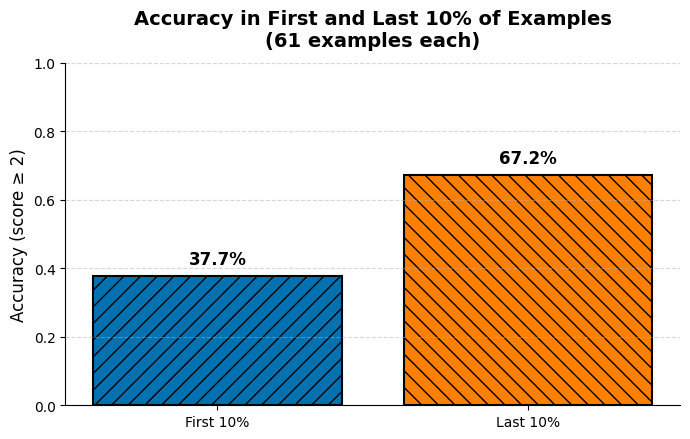

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Color-blind friendly colors and hatching
cbf_blue = "#0072B2"
cbf_orange = "#FF7F00"
bar_colors = [cbf_blue, cbf_orange]
bar_hatch = ['//', '\\\\']

# Calculate the number of rows for 10%
n = len(df)
n_10 = max(1, int(n * 0.1))

# Get indices for first 10% and last 10%
first_10_idx = df.index[:n_10]
last_10_idx = df.index[-n_10:]

# Calculate accuracy (fraction of score >= 2) in first 10% and last 10%
first_10_acc = (df.loc[first_10_idx, 'score'] >= 2).mean()
last_10_acc = (df.loc[last_10_idx, 'score'] >= 2).mean()

# Bar chart
labels = ['First 10%', 'Last 10%']
accuracies = [first_10_acc, last_10_acc]

fig, ax = plt.subplots(figsize=(7, 4.5))
bars = ax.bar(labels, accuracies, color=bar_colors, edgecolor='black', linewidth=1.5)

# Add hatching for style
for bar, hatch in zip(bars, bar_hatch):
    bar.set_hatch(hatch)

# Add value labels above bars, bold and larger font
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax.annotate(f"{acc*100:.1f}%",
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 6),  # 6 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom',
                fontsize=12, fontweight='bold')

ax.set_ylim(0, 1)
ax.set_ylabel('Accuracy (score ≥ 2)', fontsize=12)
ax.set_title(f'Accuracy in First and Last 10% of Examples\n({n_10} examples each)', fontsize=14, fontweight='bold', pad=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('long_term_memory_experiment_part_deux_first_10_percent.png', dpi=300, bbox_inches='tight')
plt.show()


In [41]:
first_not_nan_idx = synthetic_similar_questions_df[synthetic_similar_questions_df['original_index'].notna()].index[0]
print(f'First not nan index: {first_not_nan_idx}')


First not nan index: 0


In [14]:
import pandas as pd
df = pd.read_csv("ltm_eval_results_synthetic_similar_questions.csv")

,tool_name,count
0,get_database_schema,575
1,run_sql_against_database,557
2,look_up_evidence,302
3,log_evidence,285


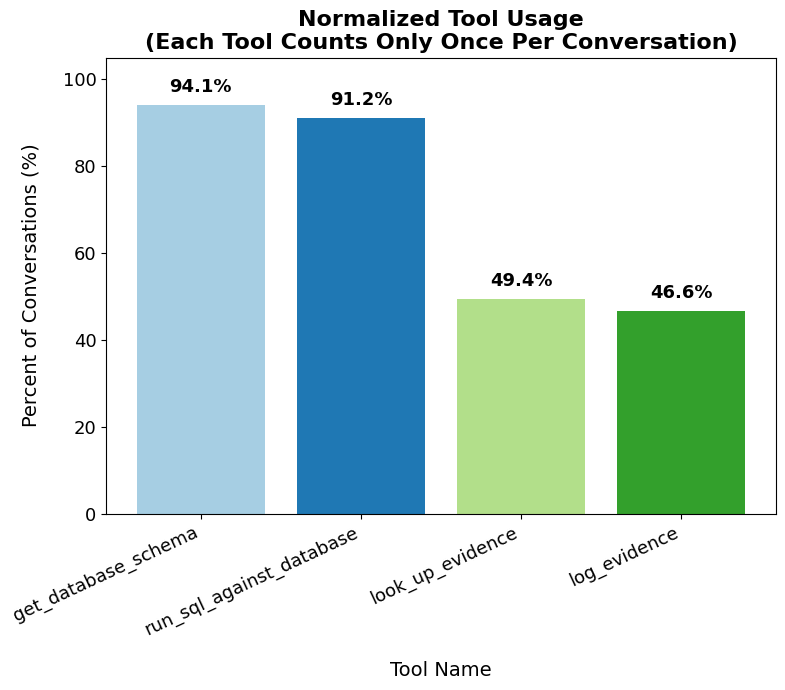

In [21]:
import ast
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

# Parse all tool_messages and extract tool names, counting each tool only once per row
tool_names = []
for msgs in df['tool_messages']:
    try:
        # Some entries may be string representations of lists of dicts
        parsed = ast.literal_eval(msgs)
        row_tools = set()
        if isinstance(parsed, list):
            for msg in parsed:
                if isinstance(msg, dict) and 'name' in msg:
                    row_tools.add(msg['name'])
        tool_names.extend(row_tools)
    except Exception as e:
        print(e)
        continue

# Count occurrences of each tool name (each tool only once per row)
tool_name_counts = Counter(tool_names)

# Show as DataFrame
tool_name_df = pd.DataFrame(tool_name_counts.items(), columns=['tool_name', 'count']).sort_values('count', ascending=False)
display(tool_name_df)

# Bar chart of normalized tool usage (percent of total rows, 0-100%)
plt.figure(figsize=(8, 7))
total_rows = df.shape[0]
tool_name_df['percent'] = tool_name_df['count'] / total_rows * 100

bars = plt.bar(tool_name_df['tool_name'], tool_name_df['percent'], color=plt.cm.Paired(range(len(tool_name_df))))
plt.title('Normalized Tool Usage\n(Each Tool Counts Only Once Per Conversation)', fontsize=16, fontweight='bold')
plt.xlabel('Tool Name', fontsize=14, labelpad=16)
plt.ylabel('Percent of Conversations (%)', fontsize=14, labelpad=16)
plt.ylim(0, 105)
plt.xticks(fontsize=13, rotation=25, ha='right')
plt.yticks(fontsize=13)
plt.subplots_adjust(bottom=0.20, left=0.18, right=0.98, top=0.88)  # Add more space for labels

# Add value labels on top of bars
for bar, pct in zip(bars, tool_name_df['percent']):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 2,
        f"{pct:.1f}%",
        ha='center',
        va='bottom',
        fontsize=13,
        fontweight='bold'
    )

plt.tight_layout(rect=[0, 0, 1, 1])
plt.savefig('tool_name_usage_normalized_part_deux.png', dpi=300, bbox_inches='tight')
plt.show()

In [8]:
df = df[['score', 'final_response', 'question', 'ground_truth_answer', 'vector_store_size']]

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate rolling mean and median
WINDOW_N = 50
print(f"Window size: {WINDOW_N}")

# Rolling mean score and rolling min vector_store_size
rolling_df = df[['score', 'vector_store_size']].rolling(window=WINDOW_N).agg({'score': 'mean', 'vector_store_size': 'min'}).dropna()

# Calculate rolling % of score >= 2
score_is_2 = (df['score'] >= 2).astype(int)
score_not_2 = (df['score'] < 2).astype(int)

rolling_pct_2 = score_is_2.rolling(window=WINDOW_N).mean().dropna()
rolling_pct_not_2 = score_not_2.rolling(window=WINDOW_N).mean().dropna()

# Add to rolling_df for convenience (align indices)
rolling_df['pct_score_2'] = rolling_pct_2.loc[rolling_df.index]
rolling_df['pct_score_not_2'] = rolling_pct_not_2.loc[rolling_df.index]

rolling_df.tail()

Window size: 50


,score,vector_store_size,pct_score_2,pct_score_not_2
606,2.02,257.0,0.72,0.28
607,1.98,257.0,0.70,0.30
608,1.94,258.0,0.68,0.32
609,1.94,258.0,0.68,0.32
610,2.00,258.0,0.70,0.30


In [10]:
df['score'].value_counts().sort_index()

score
0    234
1     78
2     61
3    238
Name: count, dtype: int64

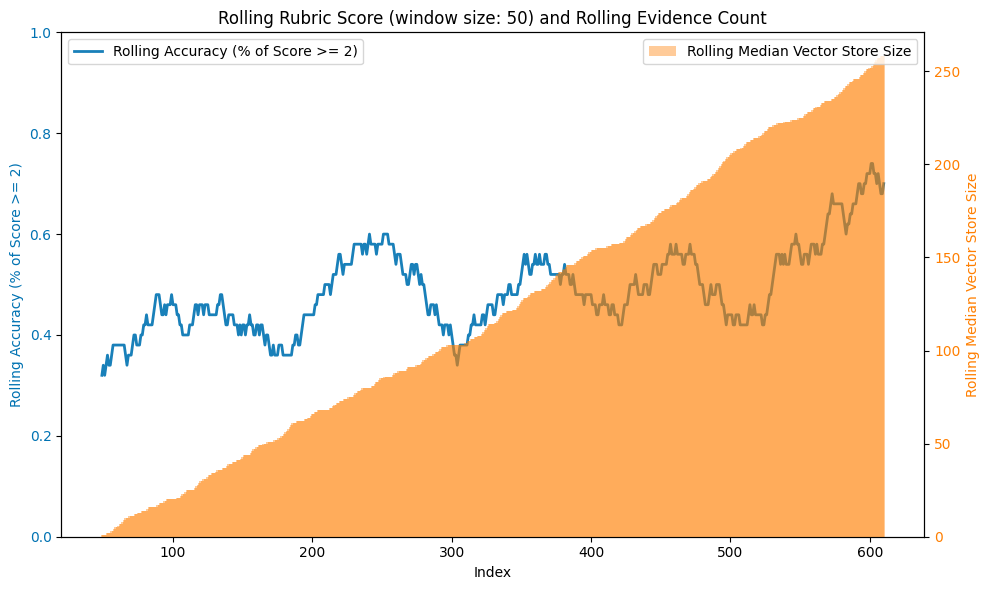

In [11]:
# Use color-blind friendly colors: blue replaced with #0072B2 (blue), orange replaced with #E69F00 (orange)
# See: https://davidmathlogic.com/colorblind/

cbf_blue = "#0072B2"
cbf_orange = "#FF7F00"

fig, ax1 = plt.subplots(figsize=(10,6))

# Use line plots for rolling mean score
ax1.plot(
    rolling_df.index,
    rolling_df['pct_score_2'],
    color=cbf_blue,
    alpha=0.9,
    label='Rolling Accuracy (% of Score >= 2)',
    linewidth=2
)
ax1.set_xlabel('Index')
ax1.set_ylabel('Rolling Accuracy (% of Score >= 2)', color=cbf_blue)
ax1.set_ylim(0, 1)
ax1.tick_params(axis='y', labelcolor=cbf_blue)

# Create a second y-axis for vector_store_size as a bar plot
ax2 = ax1.twinx()
ax2.bar(
    rolling_df.index,
    rolling_df['vector_store_size'],
    color=cbf_orange,
    alpha=0.4,
    label='Rolling Median Vector Store Size',
    width=2
)
ax2.set_ylabel('Rolling Median Vector Store Size', color=cbf_orange)
ax2.tick_params(axis='y', labelcolor=cbf_orange)

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title(f'Rolling Rubric Score (window size: {WINDOW_N}) and Rolling Evidence Count')
plt.tight_layout()
plt.savefig("long_term_memory_experiment_rolling.png")
plt.show()